In [ ]:
pip install yfinance pandas openpyxl

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime


ticker_symbol = "SPY"
ticker = yf.Ticker(ticker_symbol)

exp_dates = ticker.options
if not exp_dates:
    raise ValueError("No option expiration dates found for ticker.")

exp_date = exp_dates[0]
print(f"Using expiration date: {exp_date}")

option_chain = ticker.option_chain(exp_date)
calls_df = option_chain.calls
puts_df = option_chain.puts

calls_df["Option Type"] = "Call"
puts_df["Option Type"] = "Put"

options_df = pd.concat([calls_df, puts_df], ignore_index=True)

if len(options_df) > 100:
    options_df = options_df.head(100)

spot_price = ticker.info.get("regularMarketPrice", np.nan)
options_df["Underlying Price (Spot)"] = spot_price

today = datetime.today().date()
expiration_date = datetime.strptime(exp_date, "%Y-%m-%d").date()
time_to_maturity = (expiration_date - today).days
options_df["Time to Maturity (Days)"] = time_to_maturity

options_df["Date"] = today.strftime("%Y-%m-%d")

options_df.rename(columns={
    "strike": "Strike Price",
    "lastPrice": "Option Price (Premium)",
    "impliedVolatility": "Implied Volatility (IV)",
    "volume": "Volume",
    "openInterest": "Open Interest"
}, inplace=True)

options_df["Delta"] = np.nan
options_df["Gamma"] = np.nan
options_df["Theta"] = np.nan
options_df["Vega"] = np.nan
options_df["Rho"] = np.nan

columns_order = [
    "Date","Option Type","Underlying Price (Spot)","Strike Price","Option Price (Premium)","Implied Volatility (IV)","Time to Maturity (Days)","Delta","Gamma","Theta","Vega","Rho","Volume","Open Interest"
]

options_df = options_df[columns_order]

excel_file = "extracted_option_data.xlsx"
options_df.to_excel(excel_file, index=False)

print(f"Data successfully written to {excel_file}")

Using expiration date: 2025-02-25
Data successfully written to extracted_option_data.xlsx


In [ ]:


import yfinance as yf
import pandas as pd
import numpy as np
import math
from math import log, sqrt, exp
from datetime import datetime
from scipy.stats import norm

def black_scholes_greeks(S, K, T, r, sigma, option_type="call"):
    """
    Calculate Black-Scholes Greeks for a European option.

    Parameters:
    -----------
    S : float
        Current underlying asset price (spot).
    K : float
        Strike price.
    T : float
        Time to maturity in years.
    r : float
        Annual risk-free interest rate.
    sigma : float
        Annual implied volatility (decimal form).
    option_type : str
        'call' or 'put'.

    Returns:
    --------
    A dictionary with keys: 'delta', 'gamma', 'theta', 'vega', 'rho'
    """
    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        return {"delta": np.nan, "gamma": np.nan, "theta": np.nan,
                "vega": np.nan, "rho": np.nan}

    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    if option_type.lower() == "call":
        delta = norm.cdf(d1)
        gamma = norm.pdf(d1) / (S * sigma * sqrt(T))
        theta = ( - (S * norm.pdf(d1) * sigma) / (2.0 * sqrt(T))
                  - r * K * exp(-r * T) * norm.cdf(d2) )
        vega = S * norm.pdf(d1) * sqrt(T) * 0.01
        rho = K * T * exp(-r * T) * norm.cdf(d2) * 0.01
    else:
        delta = norm.cdf(d1) - 1
        gamma = norm.pdf(d1) / (S * sigma * sqrt(T))
        theta = ( - (S * norm.pdf(d1) * sigma) / (2.0 * sqrt(T))
                  + r * K * exp(-r * T) * norm.cdf(-d2) )
        vega = S * norm.pdf(d1) * sqrt(T) * 0.01
        rho = -K * T * exp(-r * T) * norm.cdf(-d2) * 0.01

    return {
        "delta": delta,
        "gamma": gamma,
        "theta": theta,
        "vega": vega,
        "rho": rho
    }


ticker_symbol = "SPY"
ticker = yf.Ticker(ticker_symbol)

all_exp_dates = ticker.options
if not all_exp_dates:
    raise ValueError("No option expiration dates found for this ticker.")
desired_date_str = "2023-05-01"





today_date = datetime.strptime(desired_date_str, "%Y-%m-%d").date()

future_exp_dates = [
    d for d in all_exp_dates
    if datetime.strptime(d, "%Y-%m-%d").date() > today_date
]

if not future_exp_dates:
    raise ValueError("No valid future expiration dates found. All are expired or same-day expiry.")

exp_date = future_exp_dates[0]
print(f"Using future expiration date: {exp_date}")

option_chain = ticker.option_chain(exp_date)
calls_df = option_chain.calls
puts_df = option_chain.puts

calls_df["Option Type"] = "Call"
puts_df["Option Type"] = "Put"

options_df = pd.concat([calls_df, puts_df], ignore_index=True)

spot_price = ticker.info.get("regularMarketPrice", np.nan)

expiration_date = datetime.strptime(exp_date, "%Y-%m-%d").date()
days_to_maturity = (expiration_date - today_date).days

options_df.rename(columns={
    "strike": "Strike Price",
    "lastPrice": "Option Price (Premium)",
    "impliedVolatility": "Implied Volatility (IV)",
    "volume": "Volume",
    "openInterest": "Open Interest"
}, inplace=True)

options_df["Time to Maturity (Days)"] = days_to_maturity
options_df["Underlying Price (Spot)"] = spot_price
options_df["Date"] = today_date.strftime("%Y-%m-%d")

options_df["Delta"] = np.nan
options_df["Gamma"] = np.nan
options_df["Theta"] = np.nan
options_df["Vega"] = np.nan
options_df["Rho"] = np.nan

risk_free_rate = 0.02

for i, row in options_df.iterrows():
    T = row["Time to Maturity (Days)"] / 365.0
    iv = row["Implied Volatility (IV)"]

    if pd.isna(iv) or iv == 0 or T <= 0:
        continue

    S = spot_price
    K = row["Strike Price"]
    option_type = row["Option Type"].lower()

    greeks = black_scholes_greeks(S, K, T, risk_free_rate, iv, option_type)

    options_df.at[i, "Delta"] = greeks["delta"]
    options_df.at[i, "Gamma"] = greeks["gamma"]
    options_df.at[i, "Theta"] = greeks["theta"]
    options_df.at[i, "Vega"]  = greeks["vega"]
    options_df.at[i, "Rho"]   = greeks["rho"]

columns_order = [
    "Date",
    "Option Type",
    "Underlying Price (Spot)",
    "Strike Price",
    "Option Price (Premium)",
    "Implied Volatility (IV)",
    "Time to Maturity (Days)",
    "Delta",
    "Gamma",
    "Theta",
    "Vega",
    "Rho",
    "Volume",
    "Open Interest"
]
options_df = options_df[columns_order]

if len(options_df) > 100:
    options_df = options_df.head(100)

excel_file = "extracted_option_data.xlsx"
options_df.to_excel(excel_file, index=False)
print(f"Data successfully written to {excel_file}")

options_df.head()

Using future expiration date: 2025-02-25
Data successfully written to extracted_option_data.xlsx


,Date,Option Type,Underlying Price (Spot),Strike Price,Option Price (Premium),Implied Volatility (IV),Time to Maturity (Days),Delta,Gamma,Theta,Vega,Rho,Volume,Open Interest
0,2023-05-01,Call,595.14,400.0,197.84,0.00001,666,1.000000,0.000000,-7.713318,0.000000,7.037082,6.0,2
1,2023-05-01,Call,595.14,430.0,180.65,2.14063,666,0.941886,0.000068,-55.558059,0.933959,0.705732,NaN,3
2,2023-05-01,Call,595.14,450.0,146.36,0.00001,666,1.000000,0.000000,-8.677482,0.000000,7.916717,1.0,1
3,2023-05-01,Call,595.14,480.0,122.29,0.00001,666,1.000000,0.000000,-9.255981,0.000000,8.444498,8.0,3
4,2023-05-01,Call,595.14,490.0,111.95,0.00001,666,1.000000,0.000000,-9.448814,0.000000,8.620425,4.0,0


Data Loaded Successfully!
DataFrame shape: (900, 14)
Preview of the data:


,Date,Option Type,Underlying Price (Spot),Strike Price,Option Price (Premium),Implied Volatility (IV),Time to Maturity (Days),Delta,Gamma,Theta,Vega,Rho,Volume,Open Interest
0,2025-02-25,Call,595.17,565,32.97,0.480962,1,0.981291,0.003053,-136.172364,0.014252,0.015171,1288.0,16
1,2025-02-25,Call,595.17,571,20.33,0.283210,1,0.997506,0.000878,-23.858958,0.002413,0.015602,3.0,3
2,2025-02-25,Call,595.17,578,15.98,0.000010,1,1.000000,0.000000,-11.559367,0.000000,0.015835,29.0,18
3,2025-02-25,Call,595.17,579,14.37,0.000010,1,1.000000,0.000000,-11.579365,0.000000,0.015862,13.0,1
4,2025-02-25,Call,595.17,580,15.62,0.000010,1,1.000000,0.000000,-11.599364,0.000000,0.015890,411.0,4



After cleaning, new shape: (900, 14)

Descriptive statistics for key numeric columns:


,Underlying Price (Spot),Strike Price,Option Price (Premium),Implied Volatility (IV),Time to Maturity (Days),Delta,Gamma,Theta,Vega,Rho,Volume,Open Interest
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,841.000000,900.000000
mean,595.154433,564.913333,10.395233,0.480125,224.444444,0.345044,0.005312,-92.392697,0.985930,0.866374,22502.423306,2412.331111
std,0.175411,66.293775,33.722035,0.557529,229.471081,0.464100,0.014141,138.275801,1.017347,3.127601,61976.490886,4313.212640
min,594.680000,400.000000,0.010000,0.000010,1.000000,-0.351546,0.000000,-1664.901443,0.000000,-6.579447,1.000000,0.000000
25%,595.170000,520.000000,0.010000,0.062509,35.000000,-0.094544,0.000079,-107.062062,0.000271,-0.162601,8.000000,52.000000
50%,595.199900,587.000000,0.010000,0.281257,86.000000,0.397061,0.001198,-44.521005,0.710371,0.188806,101.000000,568.000000
75%,595.210000,612.000000,0.370000,0.671878,421.000000,0.658245,0.004252,-11.704703,1.949304,2.450880,2415.000000,2906.750000
max,595.310000,700.000000,197.840000,3.388673,666.000000,1.000000,0.182511,-0.043411,3.160969,10.450066,319646.000000,23593.000000


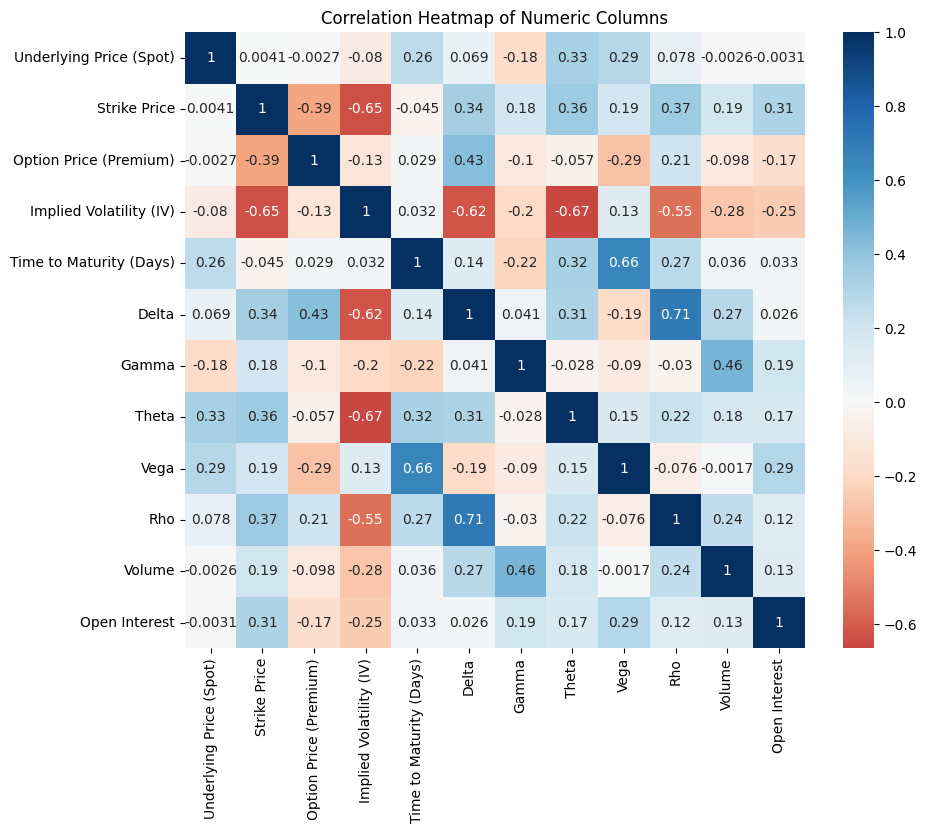

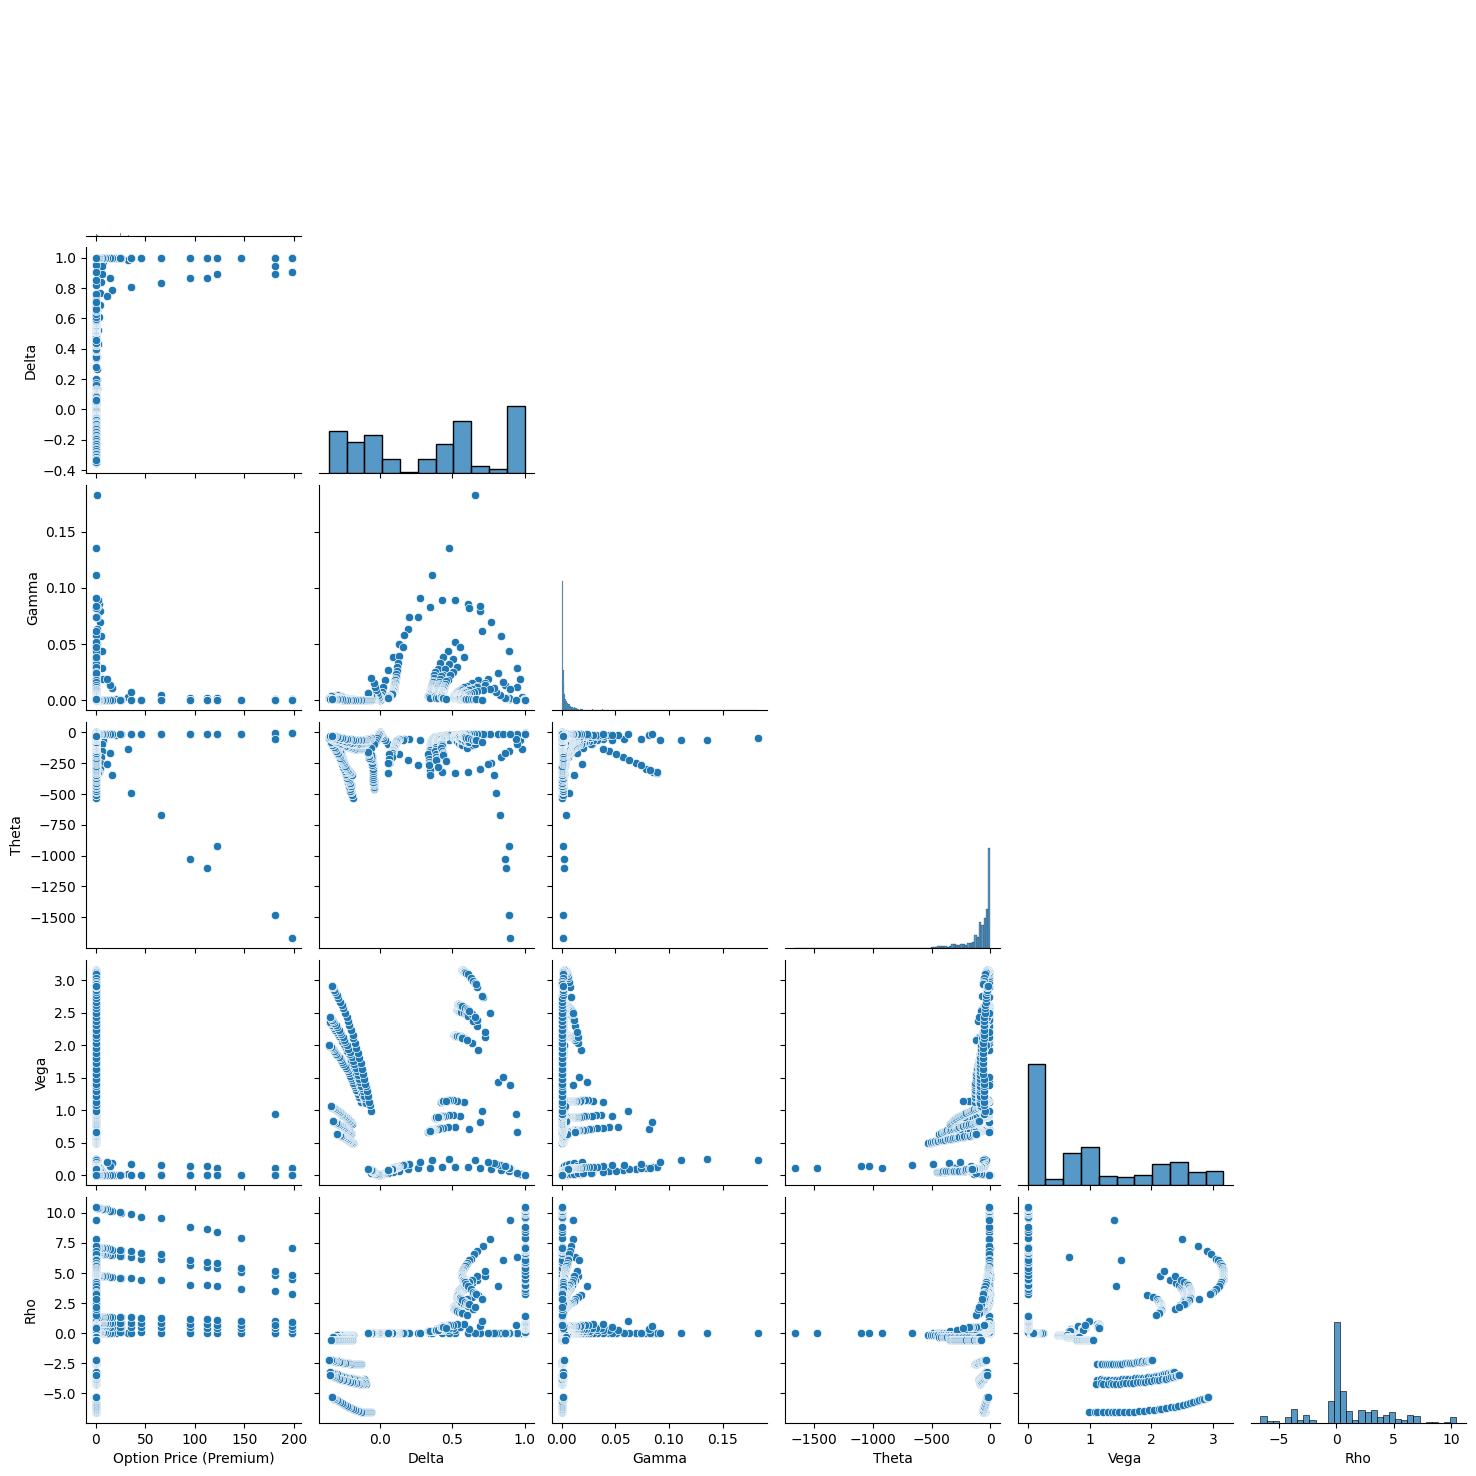

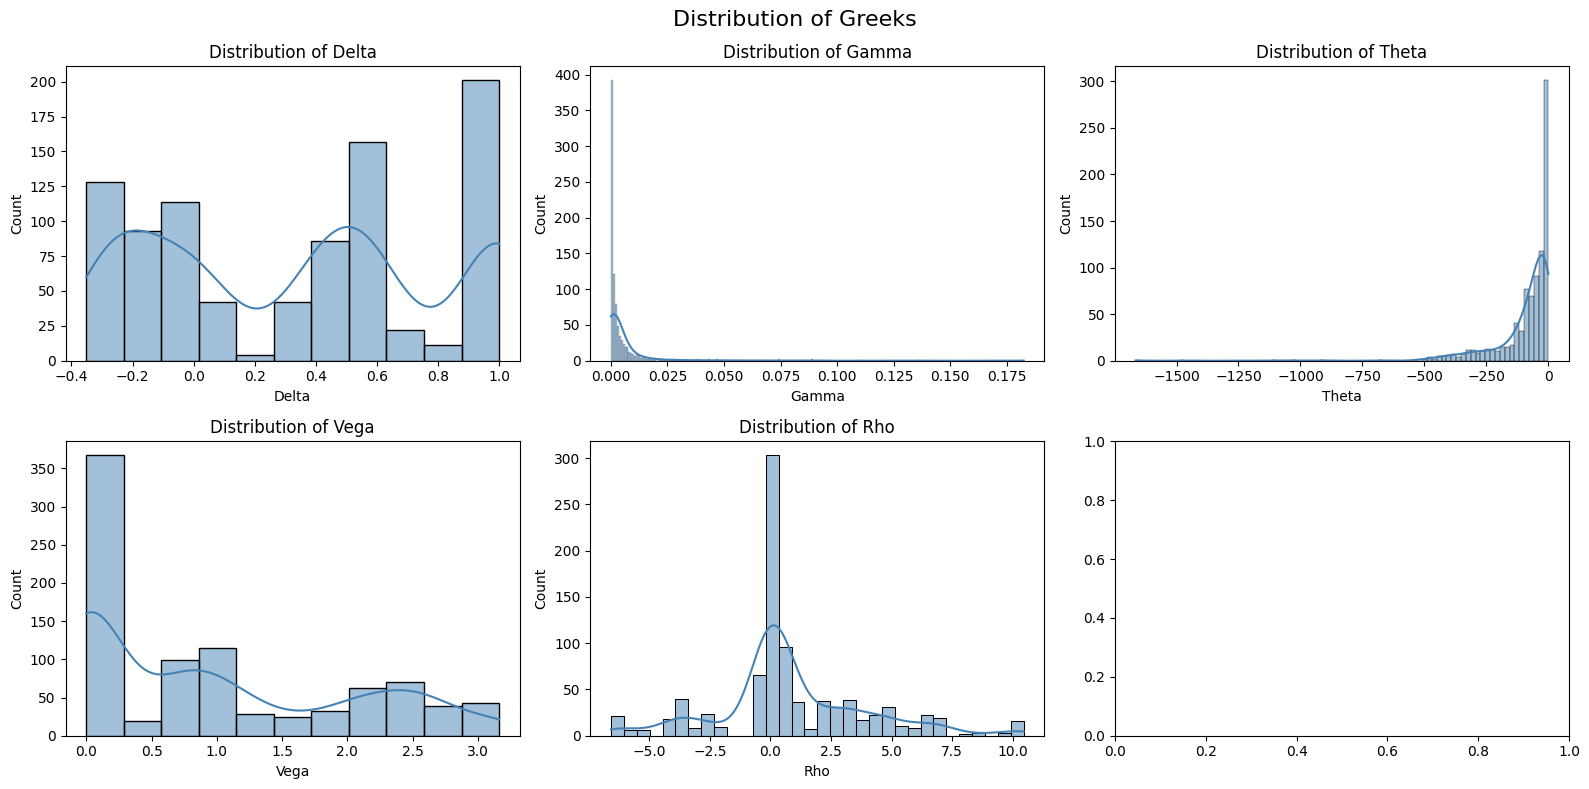


PCA Explained Variance Ratio per Component:
  PC1: 0.3776
  PC2: 0.2365
  PC3: 0.1919
  PC4: 0.1406
  PC5: 0.0533

Cumulative Explained Variance: [0.37762959 0.61416786 0.80611671 0.94667593 1.        ]


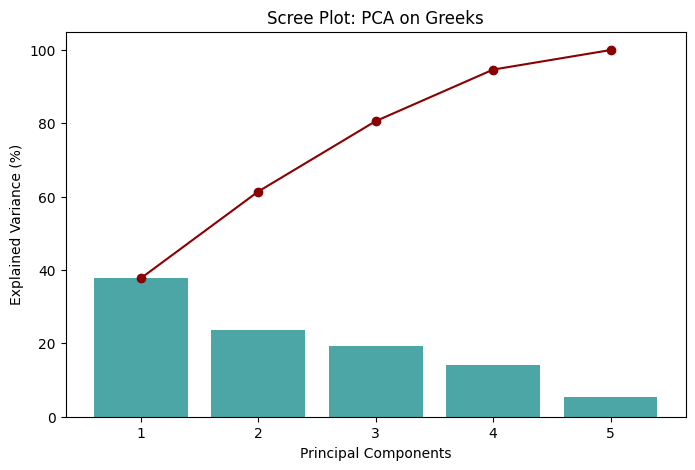

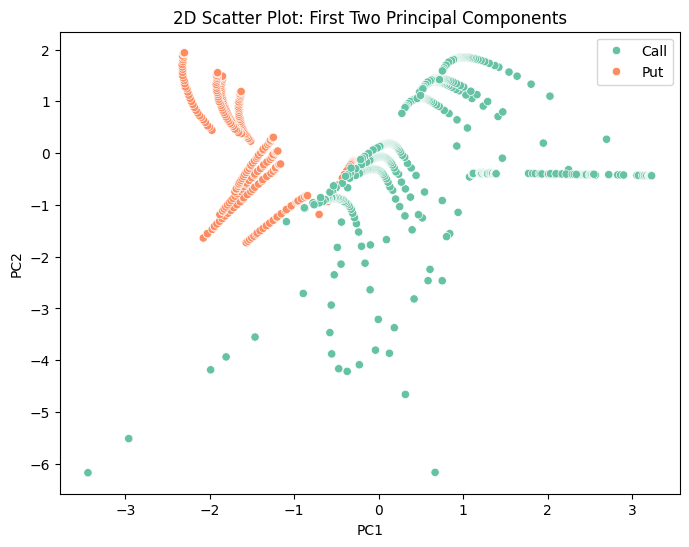


Regression Summary:
                            OLS Regression Results                            
Dep. Variable:            OptionPrice   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     71.62
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           4.40e-63
Time:                        20:13:18   Log-Likelihood:                -4291.3
No. Observations:                 900   AIC:                             8595.
Df Residuals:                     894   BIC:                             8623.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4998      2.07

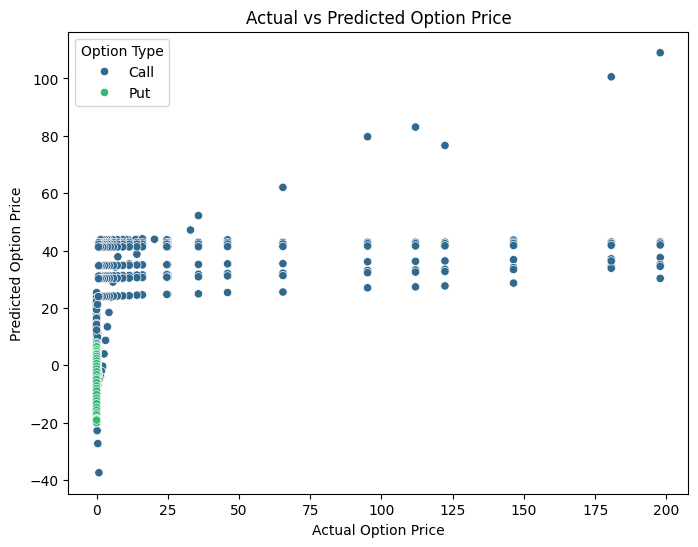

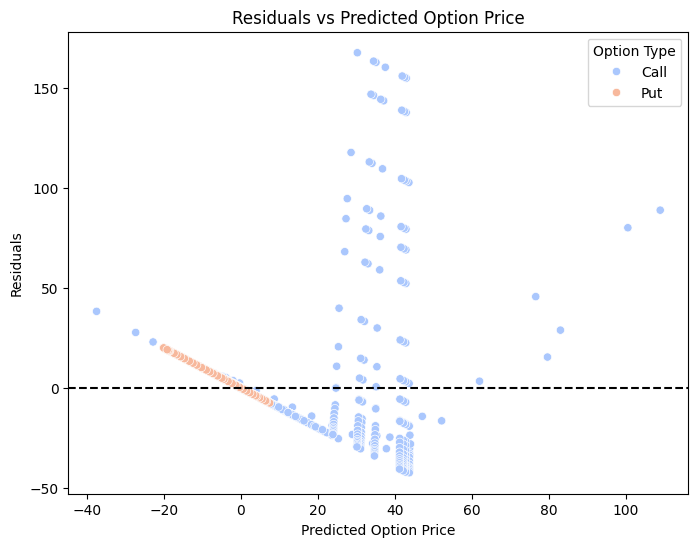

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf

excel_file = "/content/extracted_option_data (1).xlsx"

df = pd.read_excel(excel_file)

print("Data Loaded Successfully!")
print(f"DataFrame shape: {df.shape}")
print("Preview of the data:")
display(df.head())



df.drop_duplicates(inplace=True)

critical_cols = ["Delta", "Gamma", "Theta", "Vega", "Rho", "Option Price (Premium)"]
df.dropna(subset=critical_cols, inplace=True)

print("\nAfter cleaning, new shape:", df.shape)


print("\nDescriptive statistics for key numeric columns:")
numeric_cols = ["Underlying Price (Spot)", "Strike Price",
                "Option Price (Premium)", "Implied Volatility (IV)",
                "Time to Maturity (Days)", "Delta", "Gamma",
                "Theta", "Vega", "Rho", "Volume", "Open Interest"]
display(df[numeric_cols].describe())

corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu", center=0)
plt.title("Correlation Heatmap of Numeric Columns")
plt.show()






df_reg = df.rename(columns={
    "Option Price (Premium)": "OptionPrice",
    "Time to Maturity (Days)": "TTM_Days"
})

formula = "OptionPrice ~ Delta + Gamma + Theta + Vega + Rho"

model = smf.ols(formula=formula, data=df_reg).fit()
print("\nRegression Summary:")
print(model.summary())



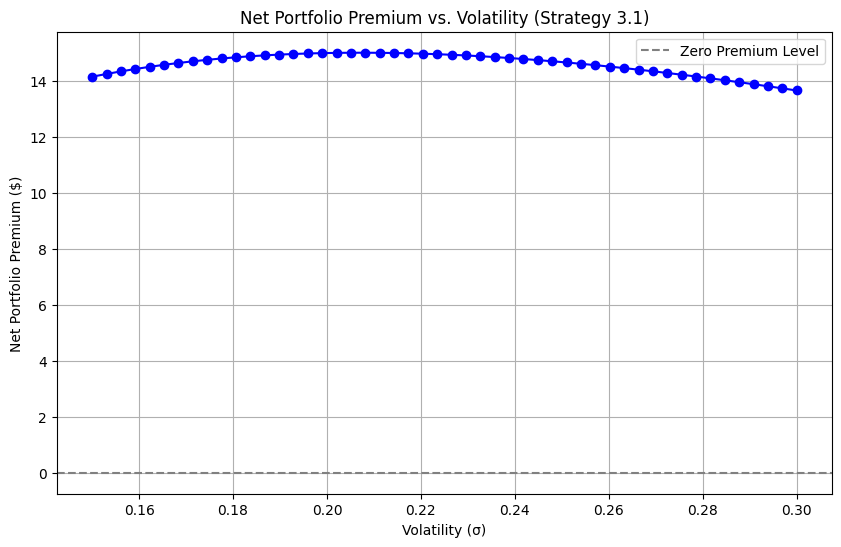

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import norm

def bs_call_price(S, K, r, sigma, T):
    """
    Compute the European call option price using the Black-Scholes formula.
    S: Current underlying price
    K: Strike price
    r: Risk-free rate
    sigma: Volatility (as a decimal)
    T: Time to expiration (in years)
    """
    if T <= 0:
        return max(S - K, 0)
    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)

def bs_put_price(S, K, r, sigma, T):
    """
    Compute the European put option price using the Black-Scholes formula.
    S: Current underlying price
    K: Strike price
    r: Risk-free rate
    sigma: Volatility (as a decimal)
    T: Time to expiration (in years)
    """
    if T <= 0:
        return max(K - S, 0)
    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return K * exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

S0 = 100.0
r = 0.01
T = 1/12

strike_call = 100
strike_put = 95

qty_long_call = 10
qty_short_put = 15

sigma_values = np.linspace(0.15, 0.30, 50)
portfolio_premiums = []

for sigma in sigma_values:
    premium_call = bs_call_price(S0, strike_call, r, sigma, T)
    premium_put = bs_put_price(S0, strike_put, r, sigma, T)

    net_premium = (qty_long_call * premium_call) - (qty_short_put * premium_put)

    portfolio_premiums.append(net_premium)

plt.figure(figsize=(10, 6))
plt.plot(sigma_values, portfolio_premiums, marker='o', linestyle='-', color='blue')
plt.title("Net Portfolio Premium vs. Volatility (Strategy 3.1)")
plt.xlabel("Volatility (σ)")
plt.ylabel("Net Portfolio Premium ($)")
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--', label="Zero Premium Level")
plt.legend()
plt.show()


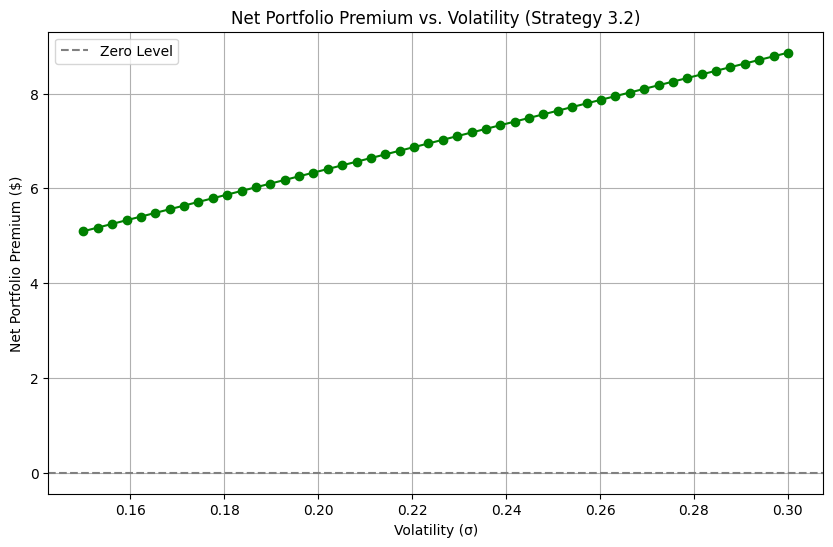

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import norm

def bs_call_price(S, K, r, sigma, T):
    """
    Compute the European call option price using the Black–Scholes formula.
    S: Current underlying price
    K: Strike price
    r: Risk-free interest rate
    sigma: Volatility (decimal)
    T: Time to expiration (years)
    """
    if T <= 0:
        return max(S - K, 0)
    d1 = (log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)

def bs_put_price(S, K, r, sigma, T):
    """
    Compute the European put option price using the Black–Scholes formula.
    S: Current underlying price
    K: Strike price
    r: Risk-free interest rate
    sigma: Volatility (decimal)
    T: Time to expiration (years)
    """
    if T <= 0:
        return max(K - S, 0)
    d1 = (log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return K * exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

S0 = 100.0
r = 0.01

T_long = 0.5
strike_long = 100
qty_long_call = 5

T_short = 1/12
strike_straddle = 100
qty_straddle = 5

sigma_values = np.linspace(0.15, 0.30, 50)
portfolio_premiums = []

for sigma in sigma_values:
    premium_long_call = bs_call_price(S0, strike_long, r, sigma, T_long)

    premium_straddle_call = bs_call_price(S0, strike_straddle, r, sigma, T_short)
    premium_straddle_put = bs_put_price(S0, strike_straddle, r, sigma, T_short)
    premium_straddle = premium_straddle_call + premium_straddle_put

    net_premium = (qty_long_call * premium_long_call) - (qty_straddle * premium_straddle)
    portfolio_premiums.append(net_premium)

plt.figure(figsize=(10,6))
plt.plot(sigma_values, portfolio_premiums, marker='o', linestyle='-', color='green')
plt.title("Net Portfolio Premium vs. Volatility (Strategy 3.2)")
plt.xlabel("Volatility (σ)")
plt.ylabel("Net Portfolio Premium ($)")
plt.axhline(0, color='gray', linestyle='--', label="Zero Level")
plt.grid(True)
plt.legend()
plt.show()


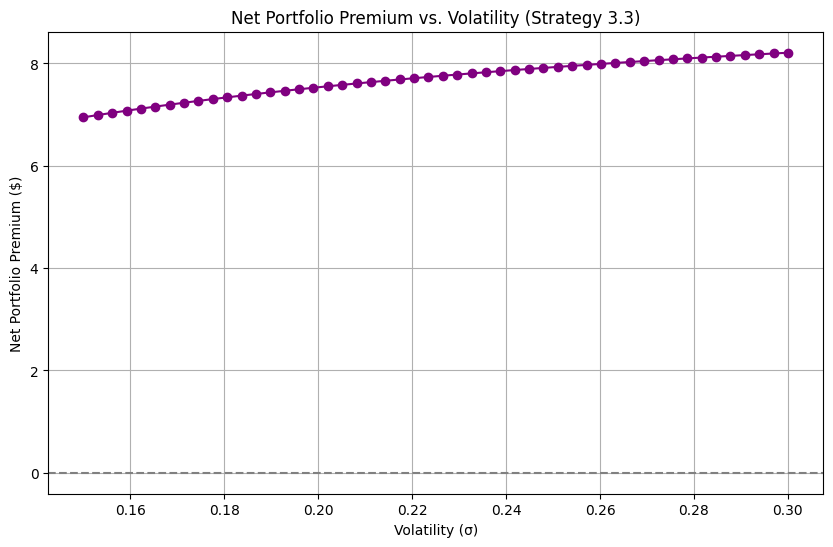

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import norm

def bs_call_price(S, K, r, sigma, T):
    if T <= 0:
        return max(S - K, 0)
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)

def bs_put_price(S, K, r, sigma, T):
    if T <= 0:
        return max(K - S, 0)
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return K * exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

S0         = 100.0
r          = 0.01

T_long     = 0.5
strike_lc  = 100
qty_lc     = 5

T_sc       = 1/12
strike_sc  = 100
qty_sc     = -7

T_sp       = 0.25
strike_sp  = 95
qty_sp     = -3

sigma_vals  = np.linspace(0.15, 0.30, 50)
net_premium = []

for sigma in sigma_vals:
    prem_lc = bs_call_price(S0, strike_lc, r, sigma, T_long)
    prem_sc = bs_call_price(S0, strike_sc, r, sigma, T_sc)
    prem_sp = bs_put_price (S0, strike_sp, r, sigma, T_sp)

    net = qty_lc*prem_lc + qty_sc*prem_sc + qty_sp*prem_sp
    net_premium.append(net)

plt.figure(figsize=(10,6))
plt.plot(sigma_vals, net_premium, marker='o', color='purple')
plt.title("Net Portfolio Premium vs. Volatility (Strategy 3.3)")
plt.xlabel("Volatility (σ)")
plt.ylabel("Net Portfolio Premium ($)")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.show()


this is after endsem exam 1

In [ ]:
!pip install yfinance --quiet

In [ ]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd

df_spot = yf.download("SPY", start="2010-01-01", end="2025-04-24")
df_spot.to_csv("spy_spot_history.csv")
print("Saved SPY spot history to spy_spot_history.csv")

ticker = yf.Ticker("SPY")

options_frames = []
for exp in ticker.options:
    chain = ticker.option_chain(exp)
    calls = chain.calls.copy()
    calls["optionType"] = "call"
    calls["expiration"] = exp
    puts = chain.puts.copy()
    puts["optionType"] = "put"
    puts["expiration"] = exp
    options_frames.extend([calls, puts])

df_options = pd.concat(options_frames, ignore_index=True)
df_options.to_csv("spy_option_chain.csv", index=False)
print("Saved SPY option chain to spy_option_chain.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Saved SPY spot history to spy_spot_history.csv
Saved SPY option chain to spy_option_chain.csv


In [ ]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd

df_spot = yf.download("SPY", start="2010-01-01", end="2025-04-24")
df_spot.to_csv("spy_spot_history.csv")
print("✅ Saved SPY spot history to spy_spot_history.csv")

ticker = yf.Ticker("SPY")
option_frames = []

for exp in ticker.options:
    chain = ticker.option_chain(exp)
    calls = chain.calls.copy()
    calls["optionType"] = "call"
    calls["expiration"] = exp
    puts = chain.puts.copy()
    puts["optionType"] = "put"
    puts["expiration"] = exp
    option_frames.extend([calls, puts])

df_options = pd.concat(option_frames, ignore_index=True)
df_options.to_csv("spy_option_chain.csv", index=False)
print("✅ Saved SPY option chain to spy_option_chain.csv")

[*********************100%***********************]  1 of 1 completed


✅ Saved SPY spot history to spy_spot_history.csv
✅ Saved SPY option chain to spy_option_chain.csv


In [ ]:
!pip install pandas==2.2.2 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 91.1 MB/s eta 0:00:00


✅  IV imputation complete.
✅ 115 rows saved to vega_comparison_results.csv


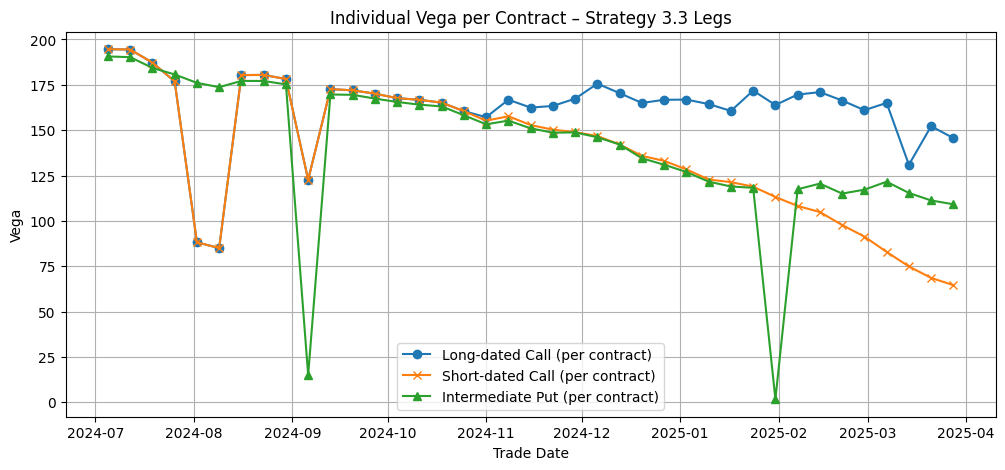

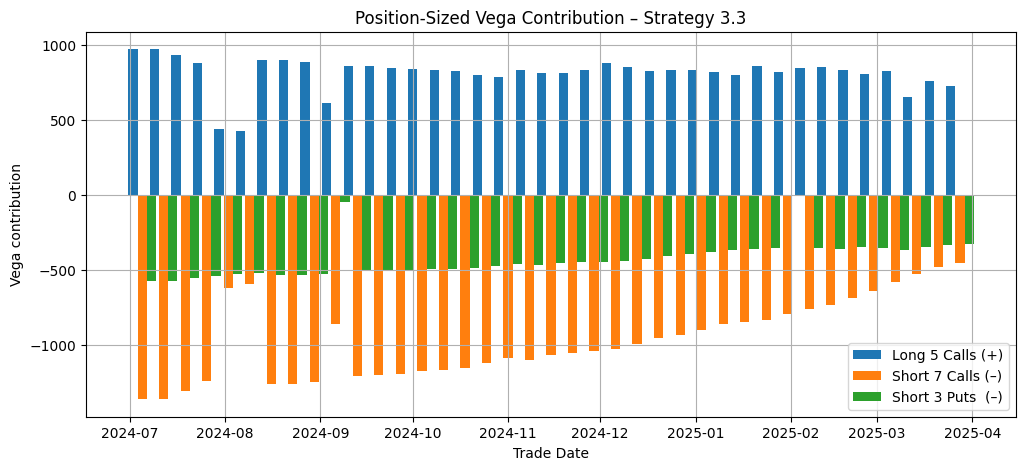

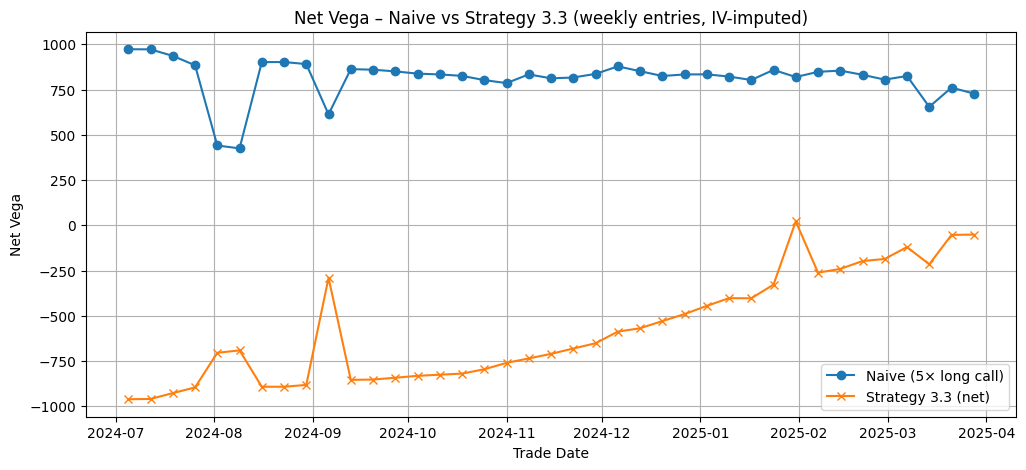

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from math import log, sqrt
from scipy.stats import norm

spot_df    = pd.read_csv("spy_spot_history.csv")
options_df = pd.read_csv("spy_option_chain.csv")

spot_df = (spot_df.rename(columns={"Date": "trade_date", "Close": "S0"})
                    .loc[:, ["trade_date", "S0"]])
spot_df["trade_date"] = pd.to_datetime(spot_df["trade_date"], dayfirst=True)
spot_df = spot_df.set_index("trade_date")

options_df["impliedVolatility"] = options_df["impliedVolatility"].astype(float)

realised_vol = (
    spot_df["S0"]
      .pct_change()
      .rolling(30).std()
      .mul(np.sqrt(252))
      .clip(lower=0.10, upper=0.40)
)


def impute_iv(row, min_iv=1e-4):
    iv = row.impliedVolatility
    if (iv > min_iv) and (not np.isnan(iv)):
        return iv
    exp = row.expiration
    typ = row.optionType
    peers = options_df[(options_df.expiration == exp) &
                       (options_df.optionType == typ) &
                       (options_df.impliedVolatility > min_iv)]
    if not peers.empty:
        return peers["impliedVolatility"].median()
    trade_dt = pd.to_datetime(exp, dayfirst=True) - pd.Timedelta(days=1)
    if trade_dt in realised_vol.index and not np.isnan(realised_vol.loc[trade_dt]):
        return realised_vol.loc[trade_dt]
    return 0.25

options_df["impliedVolatility"] = options_df.apply(impute_iv, axis=1)
print("✅  IV imputation complete.")

def bs_vega(S, K, r, sigma, T):
    if T <= 0 or sigma <= 0:
        return 0.0
    d1 = (log(S / K) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    return S * sqrt(T) * norm.pdf(d1)

def valid_iv(iv_val, min_iv=5e-4):
    return (iv_val > min_iv) and (not np.isnan(iv_val))

W_LONG, W_SCALL, W_SPUT = 5, -7, -3
r = 0.01

results = []
for trade_dt in pd.date_range("2023-01-06", "2025-04-01", freq="W-FRI"):
    if trade_dt not in spot_df.index:
        continue
    S0 = spot_df.loc[trade_dt, "S0"]

    def pick_exp(offset):
        tgt  = trade_dt + pd.Timedelta(days=offset)
        exps = sorted(options_df["expiration"].unique())
        fut  = [pd.to_datetime(e, dayfirst=True) for e in exps
                if pd.to_datetime(e, dayfirst=True) >= tgt]
        return min(fut, key=lambda d: (d - tgt).days) if fut else None

    exp_short = pick_exp(30)
    exp_inter = pick_exp(90)
    exp_long  = pick_exp(180)
    if not (exp_short and exp_inter and exp_long):
        continue

    cs = options_df[(options_df.expiration == exp_short.strftime("%d-%m-%Y")) &
                    (options_df.optionType == "call")]
    if cs.empty: continue
    strike_sc = cs.loc[(cs.strike - S0).abs().idxmin(), "strike"]
    iv_sc = cs.loc[cs.strike == strike_sc, "impliedVolatility"].values[0]
    if not valid_iv(iv_sc): continue
    vega_sc = bs_vega(S0, strike_sc, r, iv_sc, (exp_short - trade_dt).days/365)

    ps = options_df[(options_df.expiration == exp_inter.strftime("%d-%m-%Y")) &
                    (options_df.optionType == "put") & (options_df.strike < S0)]
    ps = ps.sort_values("strike", ascending=False)
    strike_sp = iv_sp = vega_sp = None
    for _, row in ps.iterrows():
        if valid_iv(row.impliedVolatility):
            strike_sp = row.strike
            iv_sp     = row.impliedVolatility
            vega_sp   = bs_vega(S0, strike_sp, r, iv_sp,
                                (exp_inter - trade_dt).days/365)
            break
    if vega_sp is None: continue

    cl = options_df[(options_df.expiration == exp_long.strftime("%d-%m-%Y")) &
                    (options_df.optionType == "call")]
    strike_lc = cl.loc[(cl.strike - S0).abs().idxmin(), "strike"]
    iv_lc = cl.loc[cl.strike == strike_lc, "impliedVolatility"].values[0]
    if not valid_iv(iv_lc): continue
    vega_lc = bs_vega(S0, strike_lc, r, iv_lc, (exp_long - trade_dt).days/365)

    naive_vega    = W_LONG * vega_lc
    strategy_vega = W_LONG*vega_lc + W_SCALL*vega_sc + W_SPUT*vega_sp

    results.append({
        "trade_date": trade_dt,
        "S0": S0,
        "vega_long_call":  vega_lc,
        "vega_short_call": vega_sc,
        "vega_short_put":  vega_sp,
        "naive_vega":     naive_vega,
        "strategy_vega":  strategy_vega
    })

if not results:
    print("No trades passed filters — relax IV threshold or widen date range.")
else:
    vega_df = pd.DataFrame(results).set_index("trade_date").sort_index()
    vega_df.to_csv("vega_comparison_results.csv")
    print(f"✅ {len(vega_df)} rows saved to vega_comparison_results.csv")
    plot_df = vega_df.loc["2024-07":"2025-04"]

    plt.figure(figsize=(12,5))
    plt.plot(plot_df.index, plot_df["vega_long_call"],  marker="o",
             label="Long-dated Call (per contract)")
    plt.plot(plot_df.index, plot_df["vega_short_call"], marker="x",
             label="Short-dated Call (per contract)")
    plt.plot(plot_df.index, plot_df["vega_short_put"],  marker="^",
             label="Intermediate Put (per contract)")
    plt.title("Individual Vega per Contract – Strategy 3.3 Legs")
    plt.xlabel("Trade Date"); plt.ylabel("Vega"); plt.legend(); plt.grid(True); plt.show()

    bw = np.timedelta64(3,"D")
    plt.figure(figsize=(12,5))
    plt.bar(plot_df.index-bw, W_LONG * plot_df["vega_long_call"],  width=bw,
            label="Long 5 Calls (+)",  color="
    plt.bar(plot_df.index,     W_SCALL*plot_df["vega_short_call"], width=bw,
            label="Short 7 Calls (–)", color="
    plt.bar(plot_df.index+bw,  W_SPUT * plot_df["vega_short_put"], width=bw,
            label="Short 3 Puts  (–)", color="
    plt.title("Position-Sized Vega Contribution – Strategy 3.3")
    plt.xlabel("Trade Date"); plt.ylabel("Vega contribution")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(plot_df.index, plot_df["naive_vega"],    marker="o", label="Naive (5× long call)")
    plt.plot(plot_df.index, plot_df["strategy_vega"], marker="x", label="Strategy 3.3 (net)")
    plt.title("Net Vega – Naive vs Strategy 3.3 (weekly entries, IV-imputed)")
    plt.xlabel("Trade Date"); plt.ylabel("Net Vega")
    plt.legend(); plt.grid(True); plt.show()

=== spot head ===
Date
2024-07-01    540.223633
2024-07-02    543.859192
2024-07-03    546.286255
2024-07-05    549.436340
2024-07-08    550.070374
Name: Close, dtype: float64 

Average 30-day ATM-call Vega: 6586.49

Chosen expiries: 2025-05-23 2025-07-31 2025-09-30 

Per-contract Vegas   LC:14188.8  SC:5908.0  SP:11004.1

Best combo (qLC,qSC,qSP) = (10, -8, -8)   → net Vega ≈ 6591.55


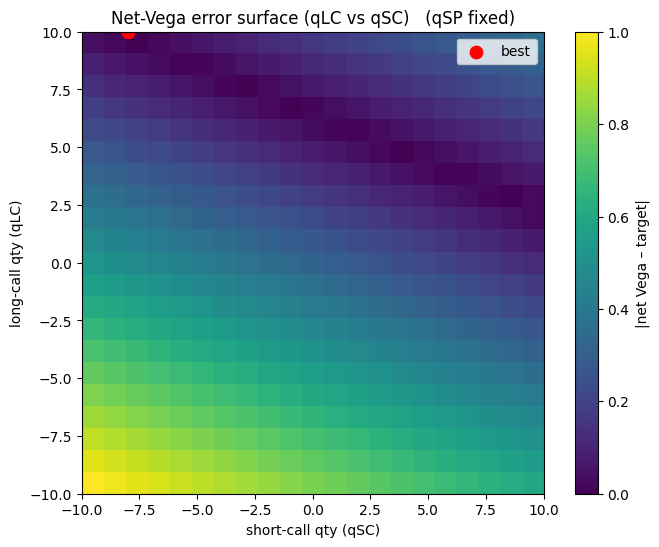

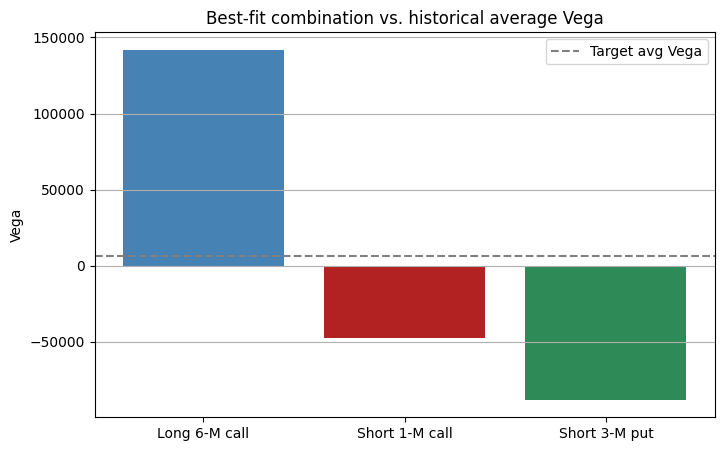

In [ ]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import norm
import itertools, datetime as dt

TICKER = "SPY"
START  = "2024-07-01"
END    = "2025-04-25"
RF     = 0.01
MAX_Q  = 10

def bs_vega(S, K, r, sigma, T):
    if T <= 0 or sigma <= 0: return 0
    d1 = (log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    return S * sqrt(T) * norm.pdf(d1)

tkr  = yf.Ticker(TICKER)
spot = tkr.history(start=START, end=END)["Close"]
spot.index = spot.index.tz_localize(None)
print("=== spot head ==="); print(spot.head(), "\n")

rv   = spot.pct_change().rolling(30).std()*np.sqrt(252)
vega_series=[]
for d in pd.date_range(START, END, freq="W-FRI"):
    if d not in spot.index or pd.isna(rv.get(d)): continue
    S  = spot.loc[d]; sigma = rv.loc[d]
    vega_series.append(bs_vega(S, S, RF, sigma, 30/365)*100)
avg_vega = np.mean(vega_series)
print(f"Average 30-day ATM-call Vega: {avg_vega:.2f}\n")

today = dt.date.today()
expiries = sorted(pd.to_datetime(tkr.options))
pick = lambda offset: min(expiries,
                          key=lambda e: abs((e.date()-today)-dt.timedelta(days=offset)))
exp_short, exp_inter, exp_long = map(pick, (30, 90, 180))
print("Chosen expiries:",
      exp_short.date(), exp_inter.date(), exp_long.date(), "\n")

S0_now = spot.iloc[-1]
atm_strk = round(S0_now/5)*5
otm_put  = atm_strk - 5

def leg_vega(exp, strike, kind):
    chain = tkr.option_chain(exp.strftime("%Y-%m-%d"))
    tbl   = chain.calls if kind=="call" else chain.puts
    row   = tbl[tbl.strike==strike]
    if row.empty: return None
    iv = max(row.impliedVolatility.values[0], 0.25)
    T  = (exp.date()-today).days/365
    return bs_vega(S0_now, strike, RF, iv, T)*100

vega_lc = leg_vega(exp_long,  atm_strk, "call")
vega_sc = leg_vega(exp_short, atm_strk, "call")
vega_sp = leg_vega(exp_inter, otm_put,  "put")

if None in (vega_lc, vega_sc, vega_sp):
    raise ValueError("Chosen strikes missing; adjust strike rounding.")

print(f"Per-contract Vegas   LC:{vega_lc:.1f}  SC:{vega_sc:.1f}  SP:{vega_sp:.1f}\n")

grid = range(-MAX_Q, MAX_Q+1)
best_combo, best_err = None, float("inf")
for q_lc, q_sc, q_sp in itertools.product(grid, repeat=3):
    net = q_lc*vega_lc + q_sc*vega_sc + q_sp*vega_sp
    err = abs(net - avg_vega)
    if err < best_err:
        best_err, best_combo = err, (q_lc, q_sc, q_sp)

q_lc, q_sc, q_sp = best_combo
net_best = q_lc*vega_lc + q_sc*vega_sc + q_sp*vega_sp
print(f"Best combo (qLC,qSC,qSP) = {best_combo}   → net Vega ≈ {net_best:.2f}")

err = np.zeros((2*MAX_Q+1,2*MAX_Q+1))
for i,q1 in enumerate(grid):
    for j,q2 in enumerate(grid):
        err[i,j] = abs(q1*vega_lc + q2*vega_sc + q_sp*vega_sp - avg_vega)

plt.figure(figsize=(8,6))
plt.imshow(err, origin="lower",
           extent=[-MAX_Q,MAX_Q,-MAX_Q,MAX_Q], cmap="viridis")
plt.scatter(q_sc, q_lc, c="red", s=80, label="best")
plt.colorbar(label="|net Vega – target|")
plt.title("Net-Vega error surface (qLC vs qSC)   (qSP fixed)")
plt.xlabel("short-call qty (qSC)"); plt.ylabel("long-call qty (qLC)")
plt.legend(); plt.show()

labels = ["Long 6-M call", "Short 1-M call", "Short 3-M put"]
vegas  = [q_lc*vega_lc, q_sc*vega_sc, q_sp*vega_sp]
plt.figure(figsize=(8,5))
plt.bar(labels, vegas, color=["steelblue","firebrick","seagreen"])
plt.axhline(avg_vega, color="gray", linestyle="--", label="Target avg Vega")
plt.title("Best-fit combination vs. historical average Vega")
plt.ylabel("Vega"); plt.legend(); plt.grid(axis="y"); plt.show()